#BCI for Sleep Stages Detection
Three models to predict sleeping stages

By:
[Mahmoud Hossam Atef](https://github.com/th3moody)
[Abdelrahman Khaled Yehia](https://github.com/abdelrahman-yehia)

**Note:** MNE was updated, thus some code changes were necessary. Using latest Sklearn and MNE.



##Installing and Importing Dependencies

In [2]:
!pip install mne
!pip install mne_features

     |████████████████████████████████| 7.4 MB 5.9 MB/s 
     |████████████████████████████████| 40 kB 5.0 MB/s 
  Created wheel for mne-features: filename=mne_features-0.2-py3-none-any.whl size=26763 sha256=e814169f9164bdd984387e0c5f89ce23a21bcc80f96cef66dc2d4c9f9a5087ff
  Stored in directory: /root/.cache/pip/wheels/50/7d/94/905a24736d6d8ecd07fb249d02af5391afed5054d26a0b66b8
Successfully built mne-features


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne_features.feature_extraction import extract_features
from mne.time_frequency import psd_welch
import seaborn as sns

import keras
from keras import layers


mne.sys_info()

Platform:       Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
Python:         3.7.12 (default, Sep 10 2021, 00:21:48)  [GCC 7.5.0]
Executable:     /usr/bin/python3
CPU:            x86_64: 2 cores
Memory:         12.7 GB

mne:            0.24.1
numpy:          1.19.5 {blas=openblas, lapack=openblas}
scipy:          1.4.1
matplotlib:     3.2.2 {backend=module://ipykernel.pylab.backend_inline}

sklearn:        1.0.1
numba:          0.51.2
nibabel:        3.0.2
nilearn:        Not found
dipy:           Not found
cupy:           Not found
pandas:         1.1.5
mayavi:         Not found
pyvista:        Not found
pyvistaqt:      Not found
ipyvtklink:     Not found
vtk:            Not found
PyQt5:          Not found
ipympl:         Not found
mne_qt_browser: Not found
pooch:          v1.5.2


## Fetching Data
16 participants training data<br>
5 participants testing data

###Load Data
While reading data, we will mark:
- the 'Temp rectal' channel as Miscellaneous channel (because it is related to the rectum not brain)(not a data channel)
- the 'Event marker' channel as Stimulus channel (because it records outer events instead of brain signals)

After reading the data, we will add annotations to it. Annotations are used to label each data point to mention in what sleep stage was this data point recorded. For example, the value at the data point number 5300 was recorded while the participant was in Sleep stage W (he was awake).

Annotations will be cropped to include the last 30 mins of awake stage before sleep and the first 30 mins of awake stage after sleep for all participants.

In [4]:
# A total of 21 paticipants data will be used 
train_participants = [i for i in range(16)]
test_participants = [i for i in range(16,21)]

mapping = { # Mapping channels to thier types manually
    'EEG Fpz-Cz' : 'eeg',
    'EEG Pz-Oz' : 'eeg',
    'EOG horizontal': 'eog',
    'Resp oro-nasal': 'resp',
    'EMG submental': 'emg',
}

# Get train participants data
train_paths = fetch_data(subjects=train_participants, recording=[1]) 
raw_train_participants = [] # Train Raw test data for participants will be saved here
for i in range(16):
  raw =  mne.io.read_raw_edf(train_paths[i][0], stim_channel='Event marker', misc=['Temp rectal'])  # Read PSG signals from an edf file
  annotations = mne.read_annotations(train_paths[i][1]) # Read signal annotations from an edf file
  # All participants had good records except the 13th (this bastard)
  if i == 12:
    annotations.crop(annotations[1]['onset'] - 30 * 60, annotations[-5]['onset'] + 30 * 60) # Annotations cropping
  else:
    annotations.crop(annotations[1]['onset'] - 30 * 60, annotations[-2]['onset'] + 30 * 60)
  raw.set_annotations(annotations)  # Set/Add annotations for the data
  raw.set_channel_types(mapping)    # Set manually channel types
  raw_train_participants.append(raw)


# Get test participants data 
test_paths = fetch_data(subjects=test_participants, recording=[1]) 
raw_test_participants = [] # Test Raw test data for participants will be saved here
for i in range(5):
  raw =  mne.io.read_raw_edf(test_paths[i][0], stim_channel='Event marker', misc=['Temp rectal'])   # Read PSG signals from an edf file
  annotations = mne.read_annotations(test_paths[i][1]) # Read signal annotations from an edf file
  annotations.crop(annotations[1]['onset'] - 30 * 60, annotations[-2]['onset'] + 30 * 60) # Cropping wasn't necessary, but to shorten the data
  raw.set_annotations(annotations)  # Set/Add annotations for the data
  raw.set_channel_types(mapping)    # Set manually channel types
  raw_test_participants.append(raw)


Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating ra

Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4161E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4171E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4181E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4191E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4201E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


###Understanding the Data
The data is a recording of 7 channels for 22 hours with frequency 100Hz.

In [5]:
# print("Info about Alice data:\n", raw_train.info) # Should be the same for all participants
print("Channels available (",len(raw_train_participants[0].ch_names) ,"):", raw_train_participants[0].ch_names)
print("Channel types:", raw_train_participants[0].get_channel_types())
print("Signal Freq:", raw_train_participants[0].info['sfreq'])
print("Recording Size: ", raw_train_participants[0].n_times,"Samples ->",
      int(raw_train_participants[0].n_times/raw_train_participants[0].info['sfreq']/60/60),"Hours") # Divining by Frequency then 60 secs then 60 mins

# raw_train_participants[0].plot()
# raw_train_participants[0].plot_psd()

# How does annotations Look? show all stages in order
# print(raw_train_participants[0].annotations.description)

print("==================")

# What was the data recorded in EEG channles at the sample X (at the x/100 second)?
x = 50000
print(raw_train_participants[0].get_data(picks=['eeg'], start=x,stop=(x+1),units='uV'))
# At which Sleeping stage was this recoding?
for annotation in raw_train_participants[0].annotations:
  if annotation['onset'] < x and x < annotation['onset'] + annotation['duration']:
    print(annotation['description'])
    break


Channels available ( 7 ): ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
Channel types: ['eeg', 'eeg', 'eog', 'resp', 'emg', 'misc', 'stim']
Signal Freq: 100.0
Recording Size:  7950000 Samples -> 22 Hours
[[-13.45641026]
 [-10.43296703]]
Sleep stage R


## First Steps

###Convert Annotations to events
We should transform our annotations into events to start making epochs.

The Sleep Physionet dataset is annotated using 8 labels: Wake (W), Stage 1, Stage 2, Stage 3, Stage 4 corresponding to the range from light sleep to deep sleep, REM sleep (R) where REM is the abbreviation for Rapid Eye Movement sleep, movement (M), and Stage (?) for any none scored segment.<br>

We cropped the annotations to include the last 30 mins before sleep and the first 30 mins after sleep. Thus there will remain 7 Sleeping stages only (Sleep stage W, Sleep stage 1, Sleep stage 2, Sleep stage 3, Sleep stage 4, Sleep stage R, and Movement).

In [6]:
# Making our own maping between annotations and events id, 
# we gave both stage 3 and 4 the same id so we can merge them later 
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5,
                              'Movement time': 6}

# Transforming for training data (event chunk size 30 seconds)
events_train = []
for i in range(16):
  events, _ = mne.events_from_annotations(raw_train_participants[i], event_id=annotation_desc_2_event_id, chunk_duration=30.0)
  events_train.append(events)


# Transforming for test data (event chunk size 30 seconds)
events_test = []
for i in range(5):
  events, _ = mne.events_from_annotations(raw_test_participants[i], event_id=annotation_desc_2_event_id, chunk_duration=30.0)
  events_test.append(events)


# The new event ids to be used
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5,
            'Movement time': 6}

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Movement time', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 

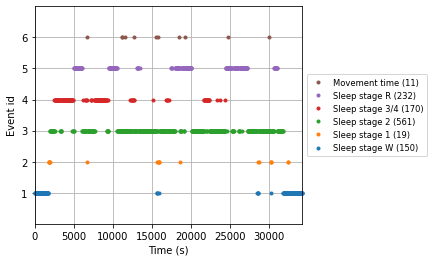

In [7]:
# Check if events were created correctly
# Plot events for a participant
x = 9
fig = mne.viz.plot_events(events_train[x], event_id=event_id, sfreq=raw_train_participants[x].info['sfreq'], first_samp=events_train[x][0, 0])
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

###Creating Epochs

In [8]:
# End time of the epochs in seconds
tmax = 30.0 - 1.0 / raw_train_participants[0].info['sfreq'] 

# reject_criteria = dict(
#                        eeg=150e-6,       # 150 µV
#                        eog=250e-6)       # 250 µV


# Event ids without movement
# Not all epochs will contain movement, thus event mapping should be changed in this situation
event_id_m = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# Create training epochs
epochs_train = []
for i in range(16):
  if 6 in set(events_train[i][:,2]):
    epochs = mne.Epochs(raw_train_participants[i],events=events_train[i],event_id=event_id ,tmin=0.0, tmax=tmax, baseline=None)
  else:
    epochs = mne.Epochs(raw_train_participants[i],events=events_train[i],event_id=event_id_m ,tmin=0.0, tmax=tmax, baseline=None)
  epochs_train.append(epochs)

# Create test epochs
epochs_test = []
for i in range(5):
  if 6 in set(events_test[i][:,2]):
    epochs = mne.Epochs(raw_test_participants[i],events=events_test[i], event_id=event_id, tmin=0.0, tmax=tmax, baseline=None)
  else:
    epochs = mne.Epochs(raw_test_participants[i],events=events_test[i], event_id=event_id_m, tmin=0.0, tmax=tmax, baseline=None)
  epochs_test.append(epochs)


Not setting metadata
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
1025 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
952 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
1236 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
843 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
976 matching events found
No baseline correction applied
0 

In [9]:
print(epochs_train[0])  # Doesn't contain movement
print(epochs_train[4])  # Contains movement

print(epochs_test[2])  # Doesn't contain movement
print(epochs_test[1])  # Contains movement

<Epochs |  841 events (good & bad), 0 - 29.99 sec, baseline off, ~13 kB, data not loaded,
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125
 'Sleep stage W': 188>
<Epochs |  1236 events (good & bad), 0 - 29.99 sec, baseline off, ~13 kB, data not loaded,
 'Movement time': 1
 'Sleep stage 1': 166
 'Sleep stage 2': 620
 'Sleep stage 3/4': 53
 'Sleep stage R': 196
 'Sleep stage W': 200>
<Epochs |  964 events (good & bad), 0 - 29.99 sec, baseline off, ~13 kB, data not loaded,
 'Sleep stage 1': 29
 'Sleep stage 2': 388
 'Sleep stage 3/4': 291
 'Sleep stage R': 118
 'Sleep stage W': 138>
<Epochs |  1003 events (good & bad), 0 - 29.99 sec, baseline off, ~13 kB, data not loaded,
 'Movement time': 1
 'Sleep stage 1': 21
 'Sleep stage 2': 328
 'Sleep stage 3/4': 215
 'Sleep stage R': 262
 'Sleep stage W': 176>


###Plot Playground

Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
250 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


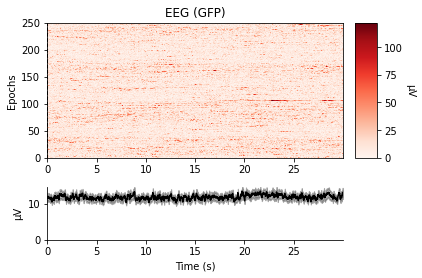

Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


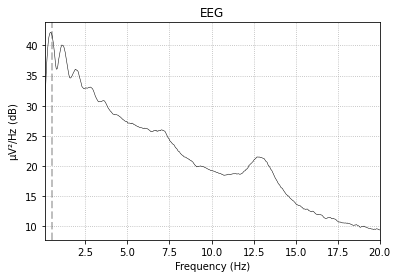

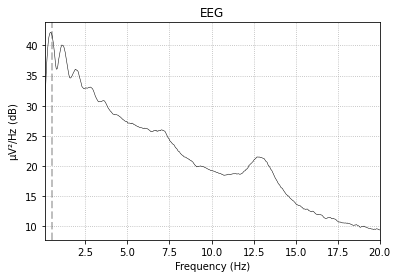

In [10]:
epochs_train[0]['Sleep stage 2'].plot_image()
fig, ax = plt.subplots(ncols=1)
epochs_train[0]['Sleep stage 2'].plot_psd(area_mode=None, ax=ax,
                              fmin=0.1, fmax=20., show=False,
                              average=True, spatial_colors=False)

#Features Extraction

In [11]:
def plot_f_dist(feat):
  fig, (ax1,ax2) = plt.subplots(ncols=2)
  stages = sorted(event_id.keys())  
  for stage in stages:
    f = feat[y==event_id[stage]]
    sns.kdeplot(f[:,0], label = stage, ax=ax1)
    sns.kdeplot(f[:,1], label = stage, ax=ax2)
  # Plot formatting
  plt.legend(title = 'Sleep Stages', loc='best',bbox_to_anchor=(1.1, 1.05))
  plt.title('Density Plot with Multiple Sleep Stages')
  plt.xlabel('V')
  plt.ylabel('Density')

In [12]:
# x = epochs_train[0].get_data()[:,:2,:]
# y = epochs_train[0].events[:,2

##Concatenate Data

In [13]:
#Extract Training Data into a list with size of participants

epochs_data_list = []
for i in range(0,16):
  epochs_data_list.append(epochs_train[i].get_data()[:,:2,:])

epochs_events_list = []
for i in range(0,16):
  epochs_events_list.append(epochs_train[i].events[:,2])

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1103 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1025 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 952 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1236 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 672 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 843 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 976 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1134 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1143 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1105 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 929 events and 3000 original time points ...
0 bad epochs droppe

In [14]:
#Concatenate Data in list
x_train = epochs_data_list[0]
for i in range(1,16):
  x_train = np.vstack((x_train,epochs_data_list[i]))
print(x_train.shape)

y = epochs_events_list[0]
for i in range(1,16):
  y = np.concatenate((y,epochs_events_list[i]), axis = 0)
print(y.shape)

(15999, 2, 3000)
(15999,)


In [15]:
#Extract Test Data into a list with size of participants

epochs_data_test = []
for i in range(0,5):
  epochs_data_test.append(epochs_test[i].get_data()[:,:2,:])

epochs_events_test = []
for i in range(0,5):
  epochs_events_test.append(epochs_test[i].events[:,2])


Loading data for 1149 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1003 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 964 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1535 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1023 events and 3000 original time points ...
0 bad epochs dropped


In [16]:
#Concatenate Data in list

x_test = epochs_data_test[0]
for i in range(1,5):
  x_test = np.vstack((x_test,epochs_data_test[i]))
print(x_test.shape)

y_test = epochs_events_test[0]
for i in range(1,5):
  y_test = np.concatenate((y_test,epochs_events_test[i]), axis = 0)
print(y_test.shape)

(5674, 2, 3000)
(5674,)


## Time Domain Features

###Standard Deviation

(15999, 2)


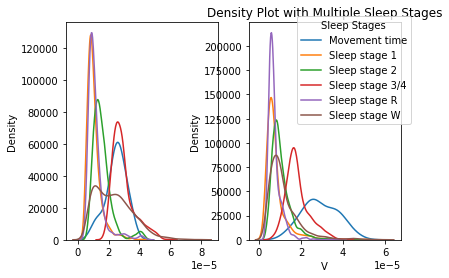

In [17]:
# Standard Deviation
f_std = x_train.std(axis=2)
print(f_std.shape)
plot_f_dist(f_std)

In [18]:
#STD Test
f_std_test = x_test.std(axis=2)
print(f_std_test.shape)

(5674, 2)


###Zero Crossing

In [19]:
# Zero Crossing
#Training Data
zero_crosses_list = []
for x in epochs_data_list:
  zero_crosses_list.append(((x[:,:,:-1] * x[:,:,1:]) < 0).sum(axis=2))

f_zero_crosses = zero_crosses_list[0]

for i in range(1,16):
  f_zero_crosses = np.vstack((f_zero_crosses, zero_crosses_list[i]))

print(f_zero_crosses.shape)

# Test Data
zero_crosses_list_test = []
for x in epochs_data_test:
  zero_crosses_list_test.append(((x[:,:,:-1] * x[:,:,1:]) < 0).sum(axis=2))

f_zero_crosses_test = zero_crosses_list_test[0]

for i in range(1,5):
  f_zero_crosses_test = np.vstack((f_zero_crosses_test, zero_crosses_list_test[i]))

print('here: ',f_zero_crosses_test.shape)

(15999, 2)
here:  (5674, 2)


###Entropy

(15999, 2)


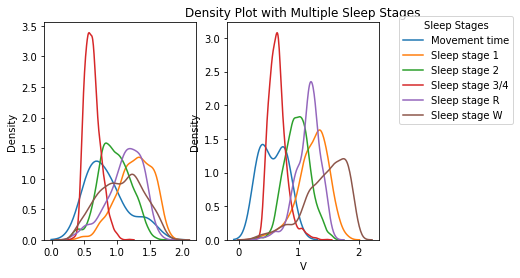

In [20]:
# Entropy
selected_funcs = {'app_entropy'}
f_entropy_list = []

for i in range(0,16):
  f_entropy_list.append(extract_features(epochs_data_list[i], raw_train_participants[i].info['sfreq'], selected_funcs))
#f_entropy = extract_features(x, raw_train_participants[0].info['sfreq'], selected_funcs)

f_entropy = f_entropy_list[0]

for i in range(1,16):
  f_entropy = np.vstack((f_entropy,f_entropy_list[i]))
print(f_entropy.shape)
plot_f_dist(f_entropy)

In [21]:
#Test Entropy
selected_funcs = {'app_entropy'}
f_entropy_test_list = []

for i in range(0,5):
  f_entropy_test_list.append(extract_features(epochs_data_test[i], raw_test_participants[i].info['sfreq'], selected_funcs))

f_entropy_test = f_entropy_test_list[0]

for i in range(1,5):
  f_entropy_test = np.vstack((f_entropy_test,f_entropy_test_list[i]))


In [22]:
print(f_entropy_test.shape)

(5674, 2)


##Frequency Domain Features



###Spectral Centriod

Loading data for 841 events and 3000 original time points ...
Effective window size : 2.560 (s)
(841, 2)
Loading data for 1103 events and 3000 original time points ...
Effective window size : 2.560 (s)
(1103, 2)
Loading data for 1025 events and 3000 original time points ...
Effective window size : 2.560 (s)
(1025, 2)
Loading data for 952 events and 3000 original time points ...
Effective window size : 2.560 (s)
(952, 2)
Loading data for 1236 events and 3000 original time points ...
Effective window size : 2.560 (s)
(1236, 2)
Loading data for 672 events and 3000 original time points ...
Effective window size : 2.560 (s)
(672, 2)
Loading data for 843 events and 3000 original time points ...
Effective window size : 2.560 (s)
(843, 2)
Loading data for 976 events and 3000 original time points ...
Effective window size : 2.560 (s)
(976, 2)
Loading data for 1134 events and 3000 original time points ...
Effective window size : 2.560 (s)
(1134, 2)
Loading data for 1143 events and 3000 original 

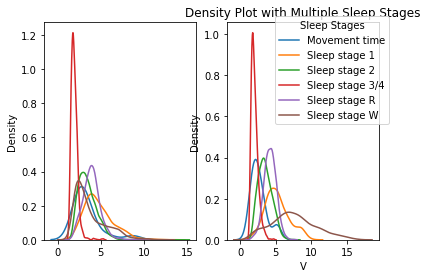

In [23]:
# psds, freqs = psd_welch(epochs_train[0], picks='eeg', fmin=0.5, fmax=30.)
# print(psds.shape)
# print(freqs.max())

# Spectral Centroid
# f_psd_spectral_cent = (psds*freqs).sum(-1)/psds.sum(-1)
# print(f_psd_spectral_cent.shape)
# plot_f_dist(f_psd_spectral_cent)

spectral_cent_list = []
for i in range(0,16):
  psds, freqs = psd_welch(epochs_train[i], picks='eeg', fmin=0.5, fmax=30.)
  curr_psd_spectral_cent = (psds*freqs).sum(-1)/psds.sum(-1)
  print(curr_psd_spectral_cent.shape)
  spectral_cent_list.append(curr_psd_spectral_cent)

f_psd_spectral_cent = spectral_cent_list[0]

for i in range(1,16):
  f_psd_spectral_cent = np.vstack((f_psd_spectral_cent, spectral_cent_list[i]))

print(f_psd_spectral_cent.shape)
plot_f_dist(f_psd_spectral_cent)


In [24]:
#Test Spectral Centriod
spectral_cent_list_test = []
for i in range(0,5):
  psds_test, freqs_test = psd_welch(epochs_test[i], picks='eeg', fmin=0.5, fmax=30.)
  curr_psd_spectral_cent_test = (psds_test*freqs_test).sum(-1)/psds_test.sum(-1)
  spectral_cent_list_test.append(curr_psd_spectral_cent_test)

f_psd_spectral_cent_test = spectral_cent_list_test[0]

for i in range(1,5):
  f_psd_spectral_cent_test = np.vstack((f_psd_spectral_cent_test, spectral_cent_list_test[i]))

print(f_psd_spectral_cent.shape)


Loading data for 1149 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1003 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 964 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1535 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1023 events and 3000 original time points ...
Effective window size : 2.560 (s)
(15999, 2)


In [25]:
print(f_psd_spectral_cent_test.shape)

(5674, 2)


###Spectral Entropy

Loading data for 841 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1103 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1025 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 952 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1236 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 672 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 843 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 976 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1134 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1143 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1105 events and 30

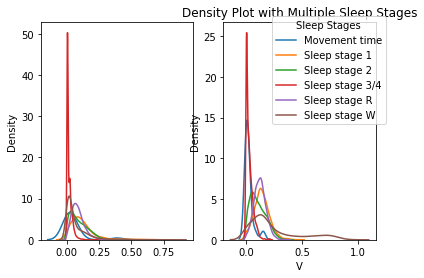

In [26]:
# Entropy
selected_funcs = {'app_entropy'}
f_psd_entropy_list = []


for i in range(0,16):
  psds, freqs = psd_welch(epochs_train[i], picks='eeg', fmin=0.5, fmax=30.)
  f_psd_entropy_list.append(extract_features(psds, raw_train_participants[i].info['sfreq'], selected_funcs))


f_psd_entropy = f_psd_entropy_list[0]

for i in range(1,16):
  f_psd_entropy = np.vstack((f_psd_entropy,f_psd_entropy_list[i]))
print(f_psd_entropy.shape)
plot_f_dist(f_psd_entropy)

f_psd_entropy_list_test = []
for i in range(0,5):
  psds, freqs = psd_welch(epochs_test[i], picks='eeg', fmin=0.5, fmax=30.)
  f_psd_entropy_list_test.append(extract_features(psds, raw_test_participants[i].info['sfreq'], selected_funcs))

f_psd_entropy_test = f_psd_entropy_list_test[0]

for i in range(1,5):
  f_psd_entropy_test = np.vstack((f_psd_entropy_test,f_psd_entropy_list_test[i]))
print(f_psd_entropy_test.shape)


###Spectral STD

Loading data for 841 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1103 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1025 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 952 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1236 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 672 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 843 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 976 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1134 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1143 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1105 events and 30

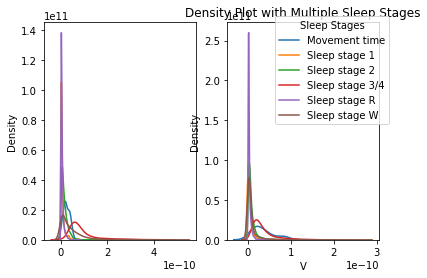

In [27]:
# Spectral STD
f_psd_std_list = []

#Training Data

for i in range(0,16):
  psds, freqs = psd_welch(epochs_train[i], picks='eeg', fmin=0.5, fmax=30.)
  f_psd_std_list.append(psds.std(axis=2))


f_psd_std = f_psd_std_list[0]

for i in range(1,16):
  f_psd_std = np.vstack((f_psd_std,f_psd_std_list[i]))
print(f_psd_std.shape)
plot_f_dist(f_psd_std)

#Test Data

f_psd_std_list_test = []
for i in range(0,5):
  psds, freqs = psd_welch(epochs_test[i], picks='eeg', fmin=0.5, fmax=30.)
  f_psd_std_list_test.append(psds.std(axis=2))

f_psd_std_test = f_psd_std_list_test[0]

for i in range(1,5):
  f_psd_std_test = np.vstack((f_psd_std_test,f_psd_std_list_test[i]))
print(f_psd_std_test.shape)


##Feature Vector Construction

In [52]:
feature_train = np.hstack((f_std, f_entropy, f_psd_spectral_cent, f_psd_entropy))
print(feature_train.shape)

feature_test = np.hstack((f_std_test, f_entropy_test, f_psd_spectral_cent_test, f_psd_entropy_test))
print(feature_test.shape)

(15999, 8)
(5674, 8)


#Model Selection

##Random Forest

###Model Training

In [53]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=35, random_state=0)
rfc.fit(feature_train, y)

RandomForestClassifier(max_depth=35, random_state=0)

###Resluts

In [54]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

print('Accuracy: ',rfc.score(feature_test,y_test)*100,'%')
y_pred = rfc.predict(feature_test)

print(classification_report(y_test, y_pred))
#print(rfc.feature_importances_)

Accuracy:  68.45259076489249 %
              precision    recall  f1-score   support

           1       0.63      0.77      0.69       981
           2       0.34      0.16      0.22       262
           3       0.73      0.82      0.77      2536
           4       0.84      0.78      0.81       785
           5       0.50      0.35      0.41      1103
           6       0.00      0.00      0.00         7

    accuracy                           0.68      5674
   macro avg       0.51      0.48      0.49      5674
weighted avg       0.67      0.68      0.67      5674



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Feature Importance

Text(0.5, 0, 'Permutation Importance')

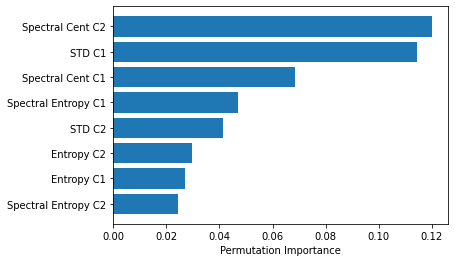

In [55]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rfc, feature_test, y_test)

feature_names = ['STD C1', 'STD C2', 'Entropy C1', 'Entropy C2', 'Spectral Cent C1', 'Spectral Cent C2' , 'Spectral Entropy C1', 'Spectral Entropy C2','Zero Crosses C1','Zero Crosses C2']
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

##SVM

###Model Training

In [62]:
from sklearn import svm

svmClf = svm.SVC()
svmClf.fit(feature_train, y)


SVC()

###Results

In [63]:
from sklearn.inspection import permutation_importance

y_pred = svmClf.predict(feature_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.62      0.63       981
           2       0.33      0.04      0.07       262
           3       0.63      0.78      0.70      2536
           4       0.78      0.71      0.75       785
           5       0.30      0.22      0.25      1103
           6       0.00      0.00      0.00         7

    accuracy                           0.60      5674
   macro avg       0.45      0.40      0.40      5674
weighted avg       0.57      0.60      0.58      5674



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Feature Importance

Text(0.5, 0, 'Permutation Importance')

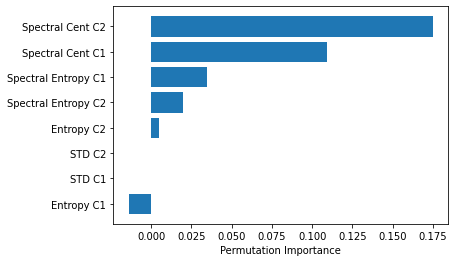

In [64]:
perm_importance = permutation_importance(svmClf, feature_test, y_test)


features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

##LDA

###Model Training

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

ldaClf = LDA()
ldaClf.fit(feature_train, y)

LinearDiscriminantAnalysis()

###Results

In [60]:
y_pred = ldaClf.predict(feature_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.89      0.58      0.70       981
           2       0.27      0.19      0.22       262
           3       0.62      0.79      0.70      2536
           4       0.80      0.56      0.66       785
           5       0.36      0.32      0.34      1103
           6       0.08      1.00      0.15         7

    accuracy                           0.60      5674
   macro avg       0.50      0.57      0.46      5674
weighted avg       0.62      0.60      0.60      5674



###Feature Importance

Text(0.5, 0, 'Permutation Importance')

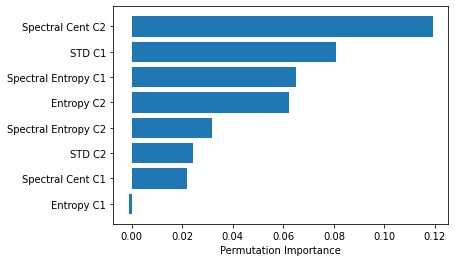

In [61]:
perm_importance = permutation_importance(ldaClf, feature_test, y_test)


features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# References
MNE Glossary: https://mne.tools/stable/glossary.html#term-data-channels <br>
STIM Channel?: https://mne.tools/stable/auto_tutorials/intro/20_events_from_raw.html#what-is-a-stim-channel <br>
Read Raw Edf: https://mne.tools/stable/generated/mne.io.read_raw_edf.html <br>
MNE Raw Object: https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.get_data <br>
MNE Annotations: https://mne.tools/stable/generated/mne.Annotations.html <br>
Annotations to Events: https://mne.tools/stable/generated/mne.events_from_annotations.html <br>
MNE Plot Events: https://mne.tools/stable/generated/mne.viz.plot_events.html <br>
MNE Epochs: https://mne.tools/stable/generated/mne.Epochs.html <br>